In [53]:
#!/usr/bin/python3
# -*-coding:utf-8
'''
Created on Sun Feb 25 2018

@author: Ray

'''
import warnings
warnings.filterwarnings("ignore")
from glob import glob
import gc
import os
from tqdm import tqdm
import time
from itertools import chain
import pandas as pd
import numpy as np
from xgboost import plot_importance
from xgboost import XGBClassifier
import utils # made by author for efficiently dealing with data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from numpy import sort
from sklearn.feature_selection import SelectFromModel # for feature selection


seed = 72
np.random.seed(seed)


In [5]:
##########################################
#load dataset
##########################################

# load dataset
train_0 = utils.load_pred_feature('trainW-0', keep_all = True)
train_1 = utils.load_pred_feature('trainW-1', keep_all = True)
train_2 = utils.load_pred_feature('trainW-2', keep_all = True)
# make data augmentation having same label distribution with training set provided by the kkbox
per_churned_in_train_0 = train_0[['is_churn']].describe().ix['mean'][0] 
n_churned = train_1[train_1.is_churn == 0].shape[0] * per_churned_in_train_0
print('per_churned_in_train_0', per_churned_in_train_0)
print('n_churned', int(n_churned))
train_1 = pd.concat([train_1[train_1.is_churn == 0],
                train_1[train_1.is_churn == 1].sample(n = int(n_churned), random_state = seed)
               ], ignore_index=True)
per_churned_in_train_1 = train_1[['is_churn']].describe().ix['mean'][0] 
print('per_churned_in_train_1', per_churned_in_train_1)
train_2 = pd.concat([train_2[train_2.is_churn == 0],
                train_2[train_2.is_churn == 1].sample(n = int(n_churned), random_state = seed)
               ], ignore_index=True)
per_churned_in_train_2 = train_1[['is_churn']].describe().ix['mean'][0] 
print('per_churned_in_train_2', per_churned_in_train_2)
train = pd.concat([train_0, train_1, train_2], ignore_index=True)

# reduce memory in python
del train_0, train_1, train_2, per_churned_in_train_0, per_churned_in_train_1, per_churned_in_train_2, n_churned,
gc.collect()

#==============================================================================
# prepare training data
#==============================================================================
Y_train = train['is_churn'] 
X_train = train.drop('is_churn', axis=1)
del train

print ('prepartion of training set is done')

  0%|          | 0/20 [00:00<?, ?it/s]

trainW-0.shape:(881896, 653)



  0%|          | 0/20 [00:00<?, ?it/s]

trainW-1.shape:(884309, 653)



100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


trainW-2.shape:(905872, 653)

per_churned_in_train_0 0.0587484238504
n_churned 10042
per_churned_in_train_1 0.0554877139084
per_churned_in_train_2 0.0554877139084
prepartion of training set is done


In [56]:
#==============================================================================
# SPLIT : Hold-out validation: only valid 1 times (for saving time)
#==============================================================================
'''
Hold-out validation vs K-fold cross-validation

Hold-out:
	- Pros:
		Only needs to be run once so has lower computational costs. It saves time.
	= Cons:
		lower generalization, it may could lead to overfitting on test set.
K-fold:
	- Pros:
		Robust to noise becuase it uses the entire training set. That is, better generalization
	- Cons:
		The model needs to be trained K times. In other words, it's  time-consuming.

In summarry,
K-fold is super expensive, so hold-out is sort of an "approximation" to what k-fold does.

Reference:
1. https://www.kdnuggets.com/2017/08/dataiku-predictive-model-holdout-cross-validation.html
2. https://stats.stackexchange.com/questions/104713/hold-out-validation-vs-cross-validation
'''
def split_build_valid(valid_size = 0.05):
    # train/val split by user
    train_user['is_valid'] = np.random.choice([0,1], size=len(train_user), 
                                              p=[1-valid_size, valid_size]) # randomly pick someone as validation user
    # is_valid: 1 if the user is validating user else 0
    valid_n = train_user['is_valid'].sum()
    build_n = (train_user.shape[0] - valid_n)
    print('build user:{}, valid user:{}'.format(build_n, valid_n))
    valid_user = train_user[train_user['is_valid']==1].msno
    is_valid = X_train.msno.isin(valid_user)
    # to create the XGBoost matrices that will be used to train the model using XGBoost. 
    x_train = X_train[~is_valid].drop('msno', axis=1)
    y_train = Y_train[~is_valid]
    x_val = X_train[is_valid].drop('msno', axis=1)
    y_val = Y_train[is_valid]
    print('FINAL SHAPE')
    print('x_train.shape:{0}'.format(x_train.shape))
    print('x_val.shape:{0}'.format(x_val.shape))

    return x_train, y_train, x_val, y_val

train_user = X_train[['msno']].drop_duplicates()
x_train, y_train, x_val, y_val = split_build_valid(valid_size = 0.05)

build user:864716, valid user:45756
FINAL SHAPE
x_train.shape:(1074190, 651)
x_val.shape:(56776, 651)


In [7]:
#==============================================================================
# Feature selection
#==============================================================================


'''
Core: essentially allowing us to test each subset of features by importance,
starting with all features and ending with a subset with the most important feature.

Operation procedures:
1. using the whole entire dataset to train a base model
2. Also, to get sorted feature importance: From the smallest to the largest, to feed into selection
3. Create a SelectFromModel instance
4. Using method of instance transfrom to reduce X to the selected features.
5. Creat a new classifier trained from the selected subset of features
6. evaluate the classifier

Notice: According to the following plotted figure, 
先初步的找出適合range of n_top_features, 可以之後再做第二次feature selection來找到更趨近最佳的n_top_features
'''
##########################################
# base_model for getting feature importance as thereshold
##########################################
s = time.time()
base_model = XGBClassifier(objective = 'binary:logistic',
                      )
base_model.fit(x_train, y_train, 
          eval_metric ='logloss' ,eval_set = [(x_val, y_val)],
          early_stopping_rounds = 10) 
e = time.time()
print ('Base_model tooks',e-s, 'secs') # Base_model tooks 4520.558794975281 secs

[0]	validation_0-logloss:0.61649
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.553748
[2]	validation_0-logloss:0.500683
[3]	validation_0-logloss:0.455863
[4]	validation_0-logloss:0.417852
[5]	validation_0-logloss:0.38522
[6]	validation_0-logloss:0.357328
[7]	validation_0-logloss:0.332865
[8]	validation_0-logloss:0.31101
[9]	validation_0-logloss:0.292094
[10]	validation_0-logloss:0.276139
[11]	validation_0-logloss:0.26175
[12]	validation_0-logloss:0.249049
[13]	validation_0-logloss:0.237978
[14]	validation_0-logloss:0.228277
[15]	validation_0-logloss:0.219684
[16]	validation_0-logloss:0.212065
[17]	validation_0-logloss:0.205413
[18]	validation_0-logloss:0.199589
[19]	validation_0-logloss:0.194519
[20]	validation_0-logloss:0.189979
[21]	validation_0-logloss:0.18615
[22]	validation_0-logloss:0.182512
[23]	validation_0-logloss:0.179343
[24]	validation_0-logloss:0.176594
[25]	validation_0-logloss:0.174201
[26]	validation_0-logloss:0.172062
[2

In [102]:
##########################################
# base_model for getting feature importance as thereshold
##########################################
s = time.time()
base_model2 = XGBClassifier(    
    objective = 'binary:logistic',
    learning_rate = 0.1,
    max_depth = 6,
    min_child_weight = 1,
    gamma = 0,
    subsample =0.8,
    colsample_bytree = 0.8,
    silent = 1.0
                      )
base_model2.fit(x_train, y_train, 
          eval_metric ='logloss' ,eval_set = [(x_val, y_val)],
          early_stopping_rounds = 40) 
e = time.time()
print ('base_model2 tooks',e-s, 'secs') # Base_model tooks 4520.558794975281 secs

[0]	validation_0-logloss:0.613229
Will train until validation_0-logloss hasn't improved in 40 rounds.
[1]	validation_0-logloss:0.547101
[2]	validation_0-logloss:0.492071
[3]	validation_0-logloss:0.44572
[4]	validation_0-logloss:0.406656
[5]	validation_0-logloss:0.372811
[6]	validation_0-logloss:0.3442
[7]	validation_0-logloss:0.318924
[8]	validation_0-logloss:0.297
[9]	validation_0-logloss:0.27793
[10]	validation_0-logloss:0.261316
[11]	validation_0-logloss:0.246778
[12]	validation_0-logloss:0.233912
[13]	validation_0-logloss:0.222595
[14]	validation_0-logloss:0.212568
[15]	validation_0-logloss:0.203857
[16]	validation_0-logloss:0.196083
[17]	validation_0-logloss:0.189092
[18]	validation_0-logloss:0.182929
[19]	validation_0-logloss:0.177536
[20]	validation_0-logloss:0.172668
[21]	validation_0-logloss:0.16845
[22]	validation_0-logloss:0.164587
[23]	validation_0-logloss:0.161338
[24]	validation_0-logloss:0.158326
[25]	validation_0-logloss:0.155638
[26]	validation_0-logloss:0.153266
[27]	

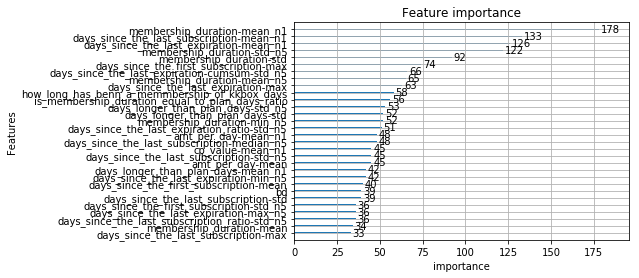

In [107]:
'''
Importance type can be defined as:
        'weight' - the number of times a feature is used to split the data across all trees.
        'gain' - the average gain of the feature when it is used in trees
        'cover' - the average coverage of the feature when it is used in trees
'''
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
plot_importance(base_model2, max_num_features = 30, importance_type='weight', xlabel='importance')
pyplot.show()

In [104]:
# Fit model using each importance as a threshold
thresholds = sort(base_model2.feature_importances_).tolist()# thresh becomes larger
thresholds

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00017129154002759606,
 0.00017129154002759606,
 0.00017129154002759606,
 0.00017129154002759606,
 0.00017129154002759606,
 0.00017129154002759606,
 0.00017129154002759606,
 0.00017129154002759606,
 0.00017129154002759606,
 

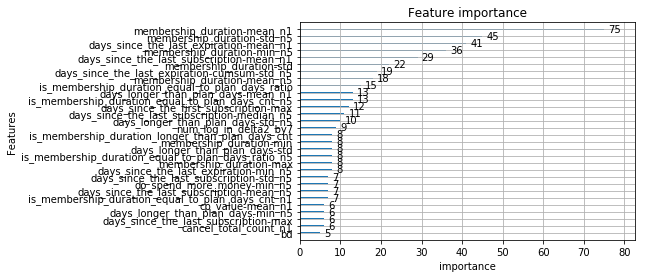

In [108]:
'''
Importance type can be defined as:
        'weight' - the number of times a feature is used to split the data across all trees.
        'gain' - the average gain of the feature when it is used in trees
        'cover' - the average coverage of the feature when it is used in trees
'''
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
plot_importance(base_model, max_num_features = 30, importance_type='weight', xlabel='importance')
pyplot.show()

In [34]:
for i,thresh in enumerate(thresholds):
    thresh_t1 = thresholds[i-1]
    if i != 0 and thresh == 0:
        continue
    if thresh_t1 == thresh:
        continue
    print('index', i,'thresh',thresh)

index 0 thresh 0.0
index 511 thresh 0.0014285714132711291
index 564 thresh 0.0028571428265422583
index 584 thresh 0.004285714123398066
index 603 thresh 0.0057142856530845165
index 616 thresh 0.0071428571827709675
index 622 thresh 0.008571428246796131
index 626 thresh 0.009999999776482582
index 630 thresh 0.011428571306169033
index 636 thresh 0.012857142835855484
index 637 thresh 0.014285714365541935
index 638 thresh 0.015714285895228386
index 639 thresh 0.017142856493592262
index 640 thresh 0.018571428954601288
index 642 thresh 0.02142857201397419
index 643 thresh 0.025714285671710968
index 644 thresh 0.027142856270074844
index 645 thresh 0.03142857179045677
index 646 thresh 0.041428569704294205
index 647 thresh 0.051428571343421936
index 648 thresh 0.058571428060531616
index 649 thresh 0.06428571790456772
index 650 thresh 0.1071428582072258


In [27]:
np.mean(thresholds)

0.0015360983022447165

In [35]:

log_loss_num_feature_plot = []

for i,thresh in enumerate(thresholds):
    # find suitable thersh for reducing features
    thresh_t1 = thresholds[i-1]
    if i != 0 and thresh == 0:
        continue
    if thresh_t1 == thresh:
        continue
    print('index', i,'thresh',thresh)
    # Hold-out validation
    x_train, y_train, x_val, y_val = split_build_valid(valid_size = 0.05)
    # selection : SelectFromModel instance
    selection = SelectFromModel(base_model, threshold = thresh, prefit = True)
    '''
    prefit: Whether a pre-fit model is expected to be passed into the constructor directly or not. 
    threshold: The threshold value to use for feature selection. Features whose importance is greater or equal are kept 
    while the others are discarded. 
 
    '''
    # select features using threshold
    select_X_train = selection.transform(x_train) # Reduce X to the selected features.
    select_X_test = selection.transform(x_val) 
    # train model
    selection_model = XGBClassifier(seed = 72) # fixed seed
    selection_model.fit(select_X_train, y_train)
    # eval model
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    #accuracy = accuracy_score(y_val, predictions)
    logloss = log_loss(y_val, predictions) 
    #acc_num_feature_plot.append((select_X_train.shape[1],accuracy))
    log_loss_num_feature_plot.append((select_X_train.shape[1],logloss))

    '''
    Honestely, It may be a more robust strategy on a larger dataset using cross validation as the model evaluation scheme.
    However, it's time-consuming. And later, we will tune feature selection again on smaller range of n_top_features.
    Therefore, here we use hold-out cross-validation for quickly reducing # features for following hyperparameter-tuning.
    '''
    print("Thresh={}, n= {}, logloss: {}".format(thresh, select_X_train.shape[1], logloss))

e = time.time()
print ('Feature selection tooks',e-s, 'secs')


index 0 thresh 0.0
build user:864914, valid user:45558
FINAL SHAPE
x_train.shape:(1074312, 651)
x_val.shape:(56654, 651)
Thresh=0.0, n= 651, logloss: 1.5582544629970287
index 511 thresh 0.0014285714132711291
build user:864826, valid user:45646
FINAL SHAPE
x_train.shape:(1074297, 651)
x_val.shape:(56669, 651)
Thresh=0.0014285714132711291, n= 140, logloss: 1.5011594021781829
index 564 thresh 0.0028571428265422583
build user:864555, valid user:45917
FINAL SHAPE
x_train.shape:(1074025, 651)
x_val.shape:(56941, 651)
Thresh=0.0028571428265422583, n= 87, logloss: 1.4879227691838777
index 584 thresh 0.004285714123398066
build user:865233, valid user:45239
FINAL SHAPE
x_train.shape:(1074626, 651)
x_val.shape:(56340, 651)
Thresh=0.004285714123398066, n= 67, logloss: 1.5301558286168835
index 603 thresh 0.0057142856530845165
build user:865225, valid user:45247
FINAL SHAPE
x_train.shape:(1074979, 651)
x_val.shape:(55987, 651)
Thresh=0.0057142856530845165, n= 48, logloss: 1.4404814900654086
index 61

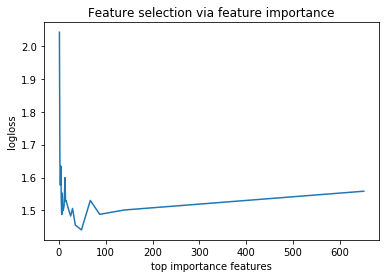

using top 48 feautues


In [39]:
####################################
# plot
####################################
import matplotlib.pyplot as plt
x = [p[0] for p in log_loss_num_feature_plot]
y = [p[1] for p in log_loss_num_feature_plot]
plt.plot(x,y)
plt.title('Feature selection via feature importance')
plt.ylabel('logloss')
plt.xlabel('top importance features')
plt.show()
# why we need feature selection
# 1. to filter the irrelevant feature improving accuracy
# 2. reducing # features increses speed of computation
print ('using top {} feautues'.format(x[y.index(min(y))]))

In [78]:
importance_dict = base_model.get_booster().get_score(importance_type='weight')
tuples = [(k, importance_dict[k]) for k in importance_dict]
max_num_features = 48
top_features = [t[0] for t in sorted(tuples, key=lambda x: x[1],reverse = True)[:max_num_features] ]
print (len(top_features))
top_features

48


['membership_duration-mean_n1',
 'membership_duration-std_n5',
 'days_since_the_last_expiration-mean_n1',
 'membership_duration-min_n5',
 'days_since_the_last_subscription-mean_n1',
 'membership_duration-std',
 'days_since_the_last_expiration-cumsum-std_n5',
 'membership_duration-mean_n5',
 'is_membership_duration_equal_to_plan_days_ratio',
 'is_membership_duration_equal_to_plan_days_cnt_n5',
 'days_longer_than_plan_days-mean_n1',
 'days_since_the_first_subscription-max',
 'days_since_the_last_subscription-median_n5',
 'days_longer_than_plan_days-std_n5',
 'num_log_in_delta2_by7',
 'days_since_the_last_expiration-min_n5',
 'membership_duration-max',
 'is_membership_duration_equal_to_plan_days_ratio_n5',
 'days_longer_than_plan_days-std',
 'membership_duration-min',
 'is_membership_duration_longer_than_plan_days_cnt',
 'is_membership_duration_equal_to_plan_days_cnt_n1',
 'days_since_the_last_subscription-mean_n5',
 'do_spend_more_money-min_n5',
 'days_since_the_last_subscription-std_n5'

72

In [98]:
####################################
# save
####################################
file_path = '../output/model/xgb_feature_tuning_seed_{}.model'.format(seed)

import pickle # for saving
# save model to file
pickle.dump(base_model, open(file_path, "wb"))
 
# some time later...
 
# load model from file
loaded_model = pickle.load(open(file_path, "rb"))

In [99]:
loaded_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [101]:
file_path

'../output/model/xgb_feature_tuning_seed_72.model'